In [164]:
import numpy as np
import ast
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
import networkx as nx

from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")

FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]

%matplotlib inline

### Load Experiments

In [165]:
time = '400'
date = '2025-01-30'
experiment = 'NEW_updated_bad_rxn'
condition = 'basal'
entry = f'{experiment}_{time}_{date}'
folder = f'out/metabolism-comparison/{condition}/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [166]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [167]:
metabolism = agent['ecoli-metabolism-redux-classic']
stoichiometry = metabolism.stoichiometry

# get concentrations
homeostatic_concs = metabolism.homeostatic_concs

### Plot Top Exchanges with Enviorment

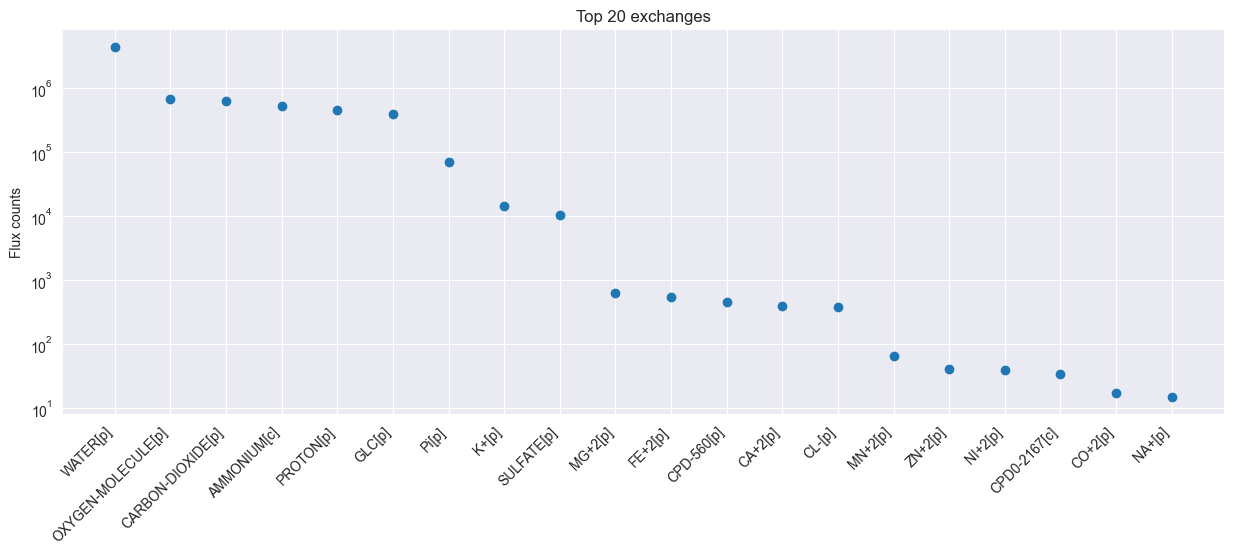

In [168]:
sim_exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
sim_exchanges = pd.DataFrame(sim_exchanges.loc[24, :].abs().sort_values(ascending=False))
sim_exchanges.head(10)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_exchanges.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_exchanges.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 20 exchanges')
plt.show()

### Plot Top 10 Reactions Flux

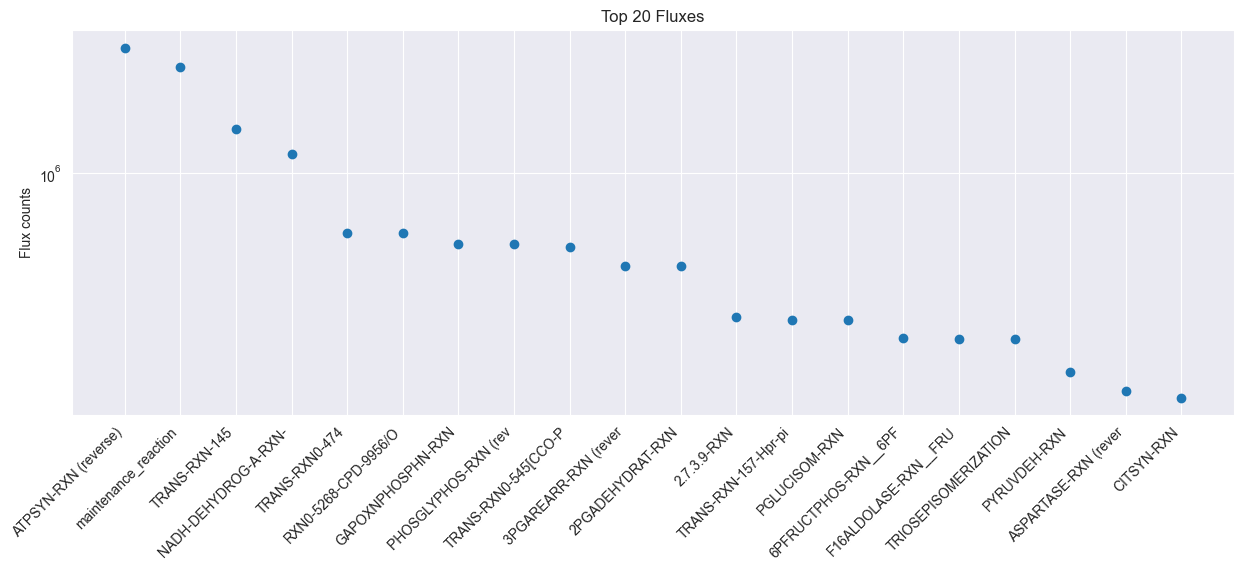

In [169]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"], columns = metabolism.reaction_names)
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))


# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar


plt.ylabel('Flux counts')
# log scale
plt.yscale('log')
plt.title('Top 20 Fluxes')
plt.show()

In [170]:
sim_catalysts = pd.DataFrame(fba["reaction_catalyst_counts"], columns=metabolism.reaction_names)
sim_catalysts = pd.DataFrame(sim_catalysts.loc[4, :].abs().sort_values(ascending=False))
sim_catalysts

,4
PEPTIDYLPROLYL-ISOMERASE-RXN[CCO-CYTOSOL]-CPD-8624//CPD-8625.32.,25727.0
RXN-19954,23548.0
RXN-19953-Reduced-Cys2-Peroxiredoxins/BUTYL-HYDROPEROXIDE//2Cys-Peroxiredoxins-With-HydroxyCys/BUTANOL.93.,23548.0
RXN0-5468,23186.0
RXN0-5468-Reduced-CcmH-Proteins/Cys2-Peroxiredoxin-Disulfide//Oxidized-CcmH-Proteins/Reduced-Cys2-Peroxiredoxins.103.,23186.0
...,...
TRANS-RXN-378-CPD-13158/ATP/WATER//CPD-13158/ADP/Pi/PROTON.45.,0.0
TRANS-RXN-161,0.0
TRANS-RXN0-224-TYLOSIN/ATP/WATER//TYLOSIN/ADP/Pi/PROTON.41.,0.0
TRANS-RXN0-224-CPD-15942/ATP/WATER//CPD-15942/ADP/Pi/PROTON.45.,0.0


### Use NetworkFlowModel class to run FBA model

In [171]:
homeostatic_count = pd.DataFrame(fba["homeostatic_metabolite_counts"], columns=metabolism.homeostatic_metabolites).loc[24, :]
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]
binary_kinetic_idx = metabolism.binary_kinetic_idx

In [172]:
model = NetworkFlowModel(
            stoich_arr=metabolism.stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=metabolism.reaction_names,
            homeostatic_metabolites=list(dict(homeostatic).keys()),
            kinetic_reactions=list(dict(kinetic).keys()),
            free_reactions=FREE_RXNS)

In [173]:
model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=metabolism.allowed_exchange_uptake)

In [174]:
objective_weights = {'secretion': 0.01, 'efficiency': 0.000001, 'kinetics': 0.0000001}
solution: FlowResult = model.solve(
            homeostatic_concs=homeostatic_count * metabolism.counts_to_molar.asNumber(), # in conc
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())) , # *10^7
            maintenance_target=maintenance, # *10^6 ish
            kinetic_targets=np.array(list(dict(kinetic).values())), # *10^6 ish
            binary_kinetic_idx=binary_kinetic_idx,
            objective_weights=objective_weights, #same
            upper_flux_bound= 1000000000, # increase to 10^9 because notebook runs FlowResult using Counts, WC runs using conc.   
            solver=cp.GLOP)

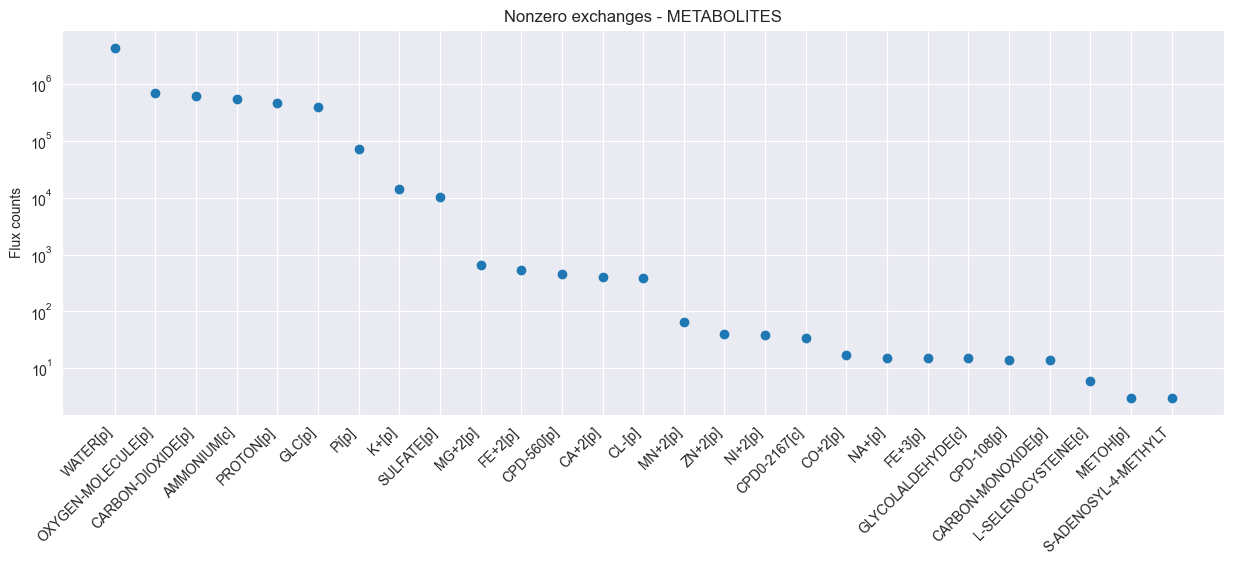

In [175]:
cur_exchanges = pd.Series(solution.exchanges, index=metabolism.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_exchanges.head(nonzero), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Nonzero exchanges - METABOLITES')
plt.show()

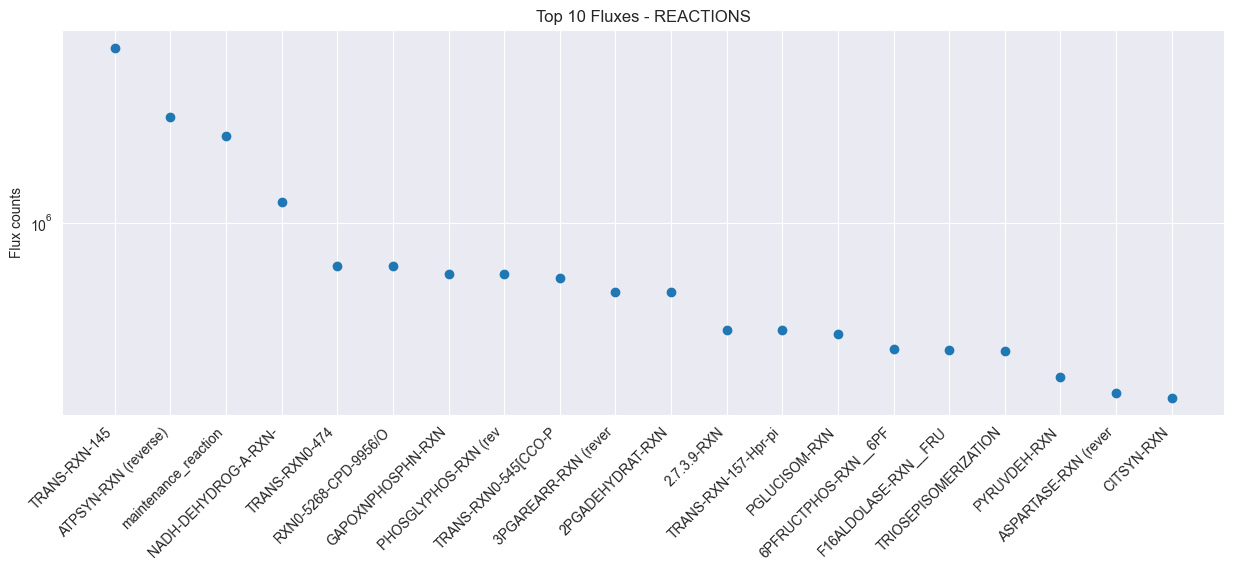

In [176]:
cur_fluxes = pd.Series(solution.velocities, index=metabolism.reaction_names).abs().sort_values(ascending=False)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in cur_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes - REACTIONS')
plt.show()

In [177]:
target_maintenance_flux = fba['maintenance_target'][24]
print(target_maintenance_flux)
cur_fluxes

2066523


TRANS-RXN-145                                                            4374211.75
ATPSYN-RXN (reverse)                                                     2438968.50
maintenance_reaction                                                     2069149.00
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.    1187267.25
TRANS-RXN0-474                                                            695272.25
                                                                            ...    
RXN0-5208                                                                      0.00
RXN0-5205                                                                      0.00
RXN0-5204                                                                      0.00
RXN0-5203                                                                      0.00
RXN0-7206-CPD-6366//CPD-6366.19. (reverse)                                     0.00
Length: 9358, dtype: float64

### Test Forcing Dead-End Metabolites

In [178]:
if metabolism.binary_kinetic_idx[0] is not None: print(1)

1
